## pygcn

In [0]:
from __future__ import print_function
from __future__ import division
import time
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import scipy.sparse as sp

In [0]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def load_data(path="./data/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges_ordered_flatten = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj1 = adj.copy()

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(270)
    idx_val = range(270, 2707)
    idx_test = range(2270, 2707)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test, adj1

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    print('rowsum shape', rowsum.shape)
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [0]:
import math
import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.encoder_gc1 = GraphConvolution(nfeat, nhid)
        self.encoder_gc2 = GraphConvolution(nhid, nclass)
        self.decoder_gc2 = GraphConvolution(nclass, nhid)
        self.decoder_gc1 = GraphConvolution(nhid, nfeat)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.encoder_gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        h = self.encoder_gc2(x, adj)
        h = F.relu(h)
        x = F.relu(self.decoder_gc2(h, adj))
        x = self.decoder_gc1(x, adj)
        return F.log_softmax(x, dim=1), h, x

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
# calculate normalized mutual info to measure the clustering performance
def cal_nmi(pred_tr, labels, n_clusters):
    nmi = normalized_mutual_info_score(labels, pred_tr, average_method='arithmetic')
    return nmi
def cal_nmi_data(data, labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(data)
    pred_tr = kmeans.labels_
    nmi = normalized_mutual_info_score(labels, pred_tr, average_method='arithmetic')
    return nmi

In [0]:
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=32,
            nclass=labels.max().item() + 1,
            dropout=0.5)
optimizer = optim.Adam(model.parameters(),
                       lr=0.01, weight_decay=5e-4)
criterion_AE = nn.MSELoss()

def train(epoch):
#     t = time.time()
    model.train()
    optimizer.zero_grad()
    output,h,x_recon = model(features, adj)# h denotes latent representations
    preds = output.max(1)[1].type_as(labels)
    loss_recon = criterion_AE(features, x_recon)
    loss_semi = F.nll_loss(output[idx_train], labels[idx_train])
    loss_train = loss_recon + loss_semi
    acc_train = accuracy(output[idx_train], labels[idx_train])
    nmi_tr = cal_nmi(preds[idx_train].data.numpy(), labels[idx_train].data.numpy(), n_clusters=7)
    nmi_tr_h = cal_nmi_data(h[idx_train].data.numpy(), labels[idx_train].data.numpy(), n_clusters=7)
    loss_train.backward()
    optimizer.step()


    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    output,h,x_recon = model(features, adj)
    preds = output.max(1)[1].type_as(labels)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    nmi_val = cal_nmi(preds[idx_val].data.numpy(), labels[idx_val].data.numpy(), n_clusters=7)
    nmi_val_h = cal_nmi_data(h[idx_val].data.numpy(), labels[idx_val].data.numpy(), n_clusters=7)
    print('Epoch: {:04d}'.format(epoch+1),
#           'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'nmi_train: {:.4f}'.format(nmi_tr),
          'nmi_train_h: {:.4f}'.format(nmi_tr_h),
#           'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'nmi_val: {:.4f}'.format(nmi_val),
          'nmi_val_h: {:.4f}'.format(nmi_val_h),          
#           'time: {:.4f}s'.format(time.time() - t),
         )
    return loss_recon, loss_semi, loss_train, nmi_tr, nmi_tr_h, nmi_val, nmi_val_h


def test():
    model.eval()
    output,h,x_recon = model(features, adj)
    preds = output.max(1)[1].type_as(labels)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    nmi_test = cal_nmi(preds[idx_test], labels[idx_test], n_clusters=7)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "nmi= {:.4f}".format(nmi_test),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
# t_total = time.time()
epochs = 800
totalloss_list=[];loss_semi_list=[];AE_list=[];nmi_train=[];nmi_train_h=[];nmi_val=[];nmi_val_h=[]
for epoch in range(epochs):
    loss_recon, loss_semi, loss_train, nmi_tr, nmi_tr_h, nmi_v, nmi_v_h = train(epoch)
    totalloss_list.append(loss_train.item()); loss_semi_list.append(loss_semi.item()); AE_list.append(loss_recon.item())
    nmi_train.append(nmi_tr); nmi_train_h.append(nmi_tr_h); nmi_val.append(nmi_v); nmi_val_h.append(nmi_v_h)
print("Optimization Finished!")
# print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()
# Plotting loss
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Epochs")
host.set_ylabel("AE-loss")
par.set_ylabel("Cross-Entropy-loss")
p1, = host.plot(range(epochs), totalloss_list, 'r-', lw=2, label="Total-loss")
p2, = host.plot(range(epochs), AE_list, 'k-', lw=2, label="AE-loss")
p3, = par.plot(range(epochs), np.array(loss_semi_list), 'b-', lw=2, label="Cross-Entropy-loss")
leg = plt.legend(loc='best')
host.yaxis.get_label().set_color(p2.get_color())
leg.texts[0].set_color(p1.get_color())
par.yaxis.get_label().set_color(p3.get_color())
leg.texts[2].set_color(p3.get_color())
plt.show()

# Plotting nmi
plt.plot( nmi_train, 'r-', lw=2, label='nmi_train')
plt.plot( nmi_train_h, 'b-', lw=2, label='nmi_train_h')
plt.plot( nmi_val, 'r--', lw=2, label='nmi_val')
plt.plot( nmi_val_h, 'b--', lw=2, label='nmi_val_h')
plt.legend(loc='upper left');
plt.show()
print("nmi_val: {:.4f}".format(np.max(nmi_val)), "nmi_val_h: {:.4f}".format(np.max(nmi_val_h)))



In [0]:
np.savez('im4-data',epochs=epochs,totalloss_list=totalloss_list,AE_list=AE_list,loss_semi_list=loss_semi_list,nmi_train=nmi_train,nmi_train_h=nmi_train_h,nmi_val=nmi_val,nmi_val_h=nmi_val_h)

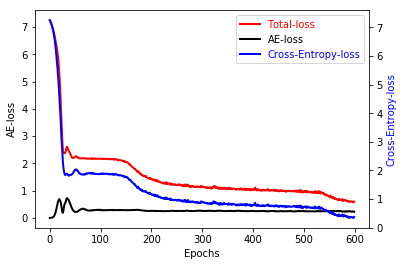

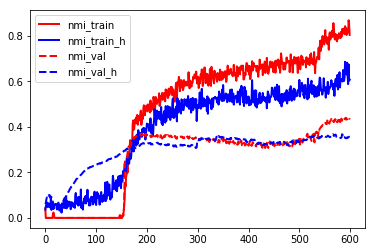

nmi_val: 0.4423 nmi_val_h: 0.3674


In [11]:
# epochs = 500
# Plotting loss
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
host = host_subplot(111)
par = host.twinx()
host.set_xlabel("Epochs")
host.set_ylabel("AE-loss")
par.set_ylabel("Cross-Entropy-loss")
p1, = host.plot(range(epochs), totalloss_list, 'r-', lw=2, label="Total-loss")
p2, = host.plot(range(epochs), AE_list, 'k-', lw=2, label="AE-loss")
p3, = par.plot(range(epochs), np.array(loss_semi_list), 'b-', lw=2, label="Cross-Entropy-loss")
leg = plt.legend(loc='best')
host.yaxis.get_label().set_color(p2.get_color())
leg.texts[0].set_color(p1.get_color())
par.yaxis.get_label().set_color(p3.get_color())
leg.texts[2].set_color(p3.get_color())
plt.show()

# Plotting nmi
plt.plot( nmi_train, 'r-', lw=2, label='nmi_train')
plt.plot( nmi_train_h, 'b-', lw=2, label='nmi_train_h')
plt.plot( nmi_val, 'r--', lw=2, label='nmi_val')
plt.plot( nmi_val_h, 'b--', lw=2, label='nmi_val_h')
plt.legend(loc='upper left');
plt.show()
print("nmi_val: {:.4f}".format(np.max(nmi_val)), "nmi_val_h: {:.4f}".format(np.max(nmi_val_h)))

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(b)
b1 = scaler.transform(b)
print(b1[:10,:10])
# def 

In [0]:
def sigmoid_cross_entropy(output, target):
    loss = -output*torch.log(target)-(1-output)*torch.log(1-target)
    loss = torch.sum(loss)
    return loss